In [1]:
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, Reshape, UpSampling2D, BatchNormalization, Activation, Input, LeakyReLU, ZeroPadding2D, Dropout, Flatten, Conv2DTranspose
from keras.optimizers import Adam
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow_addons.layers import SpectralNormalization
import numpy as np
import matplotlib.pyplot as plt
from numpy import ones
from numpy.random import randint, randn
from scipy.linalg import sqrtm
from sklearn.metrics import precision_score, recall_score
import os

c:\Users\ethan\anaconda3\envs\gpu_env2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\ethan\anaconda3\envs\gpu_env2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
def define_generator(latent_dim):
    latent_input = Input(shape=(latent_dim,))

    # Increase capacity: Add more neurons to the dense layer
    gen = Dense(256 * 8 * 8)(latent_input)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 256))(gen)

    # Increase capacity: Add more filters to the Conv2DTranspose layers
    gen = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # You can continue to add more Conv2DTranspose layers to further increase capacity

    out_layer = Conv2D(3, (3, 3), activation='tanh', padding='same')(gen)

    model = Model(latent_input, out_layer)
    return model

def define_discriminator(in_shape=(32,32,3)):
    # Image input
    image_input = Input(shape=in_shape)

    # Downsample
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same')(image_input)
    fe = LeakyReLU(alpha=0.2)(fe)

    # Downsample
    fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    # # Downsample
    # fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    # fe = LeakyReLU(alpha=0.2)(fe)

    # Flatten and output
    fe = Flatten()(fe)
    fe = Dropout(0.7)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)

    # Define model
    model = Model(image_input, out_layer)
    return model

def define_gan(g_model, d_model):
    d_model.trainable = False
    gen_noise = g_model.input
    gen_output = g_model.output
    gan_output = d_model(gen_output)
    model = Model(gen_noise, gan_output)
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # Verify that dataset is a list or tuple with two items
    # if not isinstance(dataset, (list, tuple)) or len(dataset) != 2:
    #     raise ValueError("Expected dataset to be a list or tuple of [images, labels]")

    images = dataset
    ix = randint(0, images.shape[0], n_samples)
    X = images[ix]
    y = ones((n_samples, 1))
    return X , y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    images = g_model.predict(z_input)
    y = np.zeros((n_samples, 1))
    return images, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
        # save plot to file
        filename = 'generated_plot_e%03d.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()

def calculate_fid(dataset, generated_images):
    real_images = dataset  # Extracting real images from dataset
    generated_images = np.array(generated_images) 

    # Flatten images to 2D
    real_images_2d = real_images.reshape(real_images.shape[0], -1)
    generated_images_2d = generated_images.reshape(generated_images.shape[0], -1)
    #print(real_images.shape, generated_images.shape, real_images_2d.shape, generated_images_2d.shape)

    # Calculate the mean and covariance of real and generated images
    mu1, sigma1 = real_images_2d.mean(axis=0), np.cov(real_images_2d, rowvar=False)
    mu2, sigma2 = generated_images_2d.mean(axis=0), np.cov(generated_images_2d, rowvar=False)

    # Calculate the sum of the squared difference of the means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    epsilon = 1e-6  # small regularization term
    sigma1_reg = sigma1 + epsilon * np.eye(sigma1.shape[0])
    sigma2_reg = sigma2 + epsilon * np.eye(sigma2.shape[0])
    covmean = sqrtm(sigma1_reg.dot(sigma2_reg))
    
    # Calculate sqrt of product of covariances
    #covmean = sqrtm(sigma1.dot(sigma2))
    
    # Check for imaginary numbers and convert to real
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    # Calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid


def calculate_precision_recall(dataset, generated_images):
    real_images = dataset  # Extracting real images from dataset

    # Ensure generated_images is a numpy array
    generated_images = np.array(generated_images)  # Extracting only images from generated samples

    # Ensure the same number of samples in both sets
    min_samples = min(real_images.shape[0], generated_images.shape[0])
    real_images = real_images[:min_samples]
    generated_images = generated_images[:min_samples]

    # Flatten images
    real_images_2d = real_images.reshape(min_samples, -1)
    generated_images_2d = generated_images.reshape(min_samples, -1)

    # Binarize images (assuming values are in 0-255 range)
    threshold = 128
    real_images_binarized = (real_images_2d > threshold).astype(int)
    generated_images_binarized = (generated_images_2d > threshold).astype(int)

    # Calculate precision and recall
    precision = precision_score(real_images_binarized, generated_images_binarized, average='micro', zero_division=0)
    recall = recall_score(real_images_binarized, generated_images_binarized, average='micro', zero_division=0)

    return precision, recall

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(g_model, d_model, dataset, latent_dim, n_samples=100):
    # Prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # Evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    
    # Prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # Evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    
    # Summarize discriminator performance
    print(f'>Accuracy | real: {acc_real*100:.0f}%, fake: {acc_fake*100:.0f}%')
    return acc_real, acc_fake

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch):
    metrics = {'acc_real': [], 'acc_fake': [], 'd_loss': [], 'g_loss': [], 'fid': [], 'precision': [], 'recall': []}
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    d_loss1, d_loss2, g_loss = 0.0, 0.0, 0.0  
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            z_input = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(z_input, y_gan)
            print(f'Epoch: {i+1}/{n_epochs}, Batch: {j+1}/{bat_per_epo}, D loss: {d_loss1:.3f}, G loss: {g_loss:.3f}')
            # evaluate
        if (i+1) % 5 == 0:
            acc_real, acc_fake = summarize_performance(g_model, d_model, dataset, latent_dim)
            generated_fake_images, _ = generate_fake_samples(g_model, latent_dim, 1000)
            fid = calculate_fid(dataset, generated_fake_images)
            precision, recall = calculate_precision_recall(dataset, generated_fake_images)
            metrics['acc_real'].append(acc_real)
            metrics['acc_fake'].append(acc_fake)
            metrics['d_loss'].append((d_loss1 + d_loss2) / 2)
            metrics['g_loss'].append(g_loss)
            metrics['fid'].append(fid)
            metrics['precision'].append(precision)
            metrics['recall'].append(recall)
    return metrics

In [5]:
def plot_metrics(metrics, epochs):
    # Plotting Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['acc_real'], label='Accuracy Real')
    plt.plot(epochs, metrics['acc_fake'], label='Accuracy Fake')
    plt.title('Discriminator Accuracy During Training')
    plt.xlabel('Eval')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['d_loss'], label='Discriminator Loss')
    plt.plot(epochs, metrics['g_loss'], label='Generator Loss')
    plt.title('Discriminator and Generator Loss During Training')
    plt.xlabel('Eval')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting FID, sFID, Class-aware-FID, and MiFID
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['fid'], label='FID')
    plt.title('FID During Training')
    plt.xlabel('Eval')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

2/2 [==============================] - 1s 5ms/step
Epoch: 1/50, Batch: 1/390, D loss: 0.718, G loss: 0.693
2/2 [==============================] - 0s 7ms/step
Epoch: 1/50, Batch: 2/390, D loss: 0.691, G loss: 0.692
2/2 [==============================] - 0s 7ms/step
Epoch: 1/50, Batch: 3/390, D loss: 0.688, G loss: 0.691
2/2 [==============================] - 0s 7ms/step
Epoch: 1/50, Batch: 4/390, D loss: 0.684, G loss: 0.690
2/2 [==============================] - 0s 7ms/step
Epoch: 1/50, Batch: 5/390, D loss: 0.687, G loss: 0.689
2/2 [==============================] - 0s 8ms/step
Epoch: 1/50, Batch: 6/390, D loss: 0.691, G loss: 0.688
2/2 [==============================] - 0s 6ms/step
Epoch: 1/50, Batch: 7/390, D loss: 0.690, G loss: 0.686
2/2 [==============================] - 0s 6ms/step
Epoch: 1/50, Batch: 8/390, D loss: 0.671, G loss: 0.685
2/2 [==============================] - 0s 7ms/step
Epoch: 1/50, Batch: 9/390, D loss: 0.679, G loss: 0.683
2/2 [==============================] 

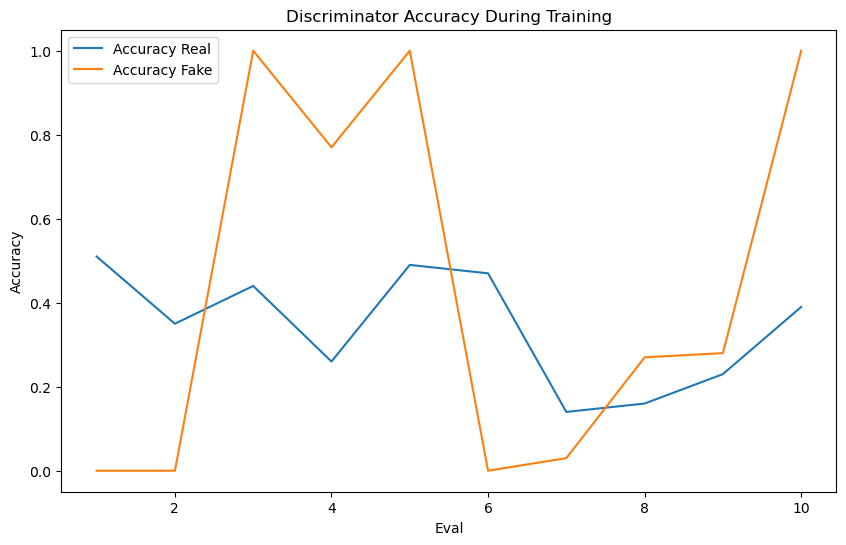

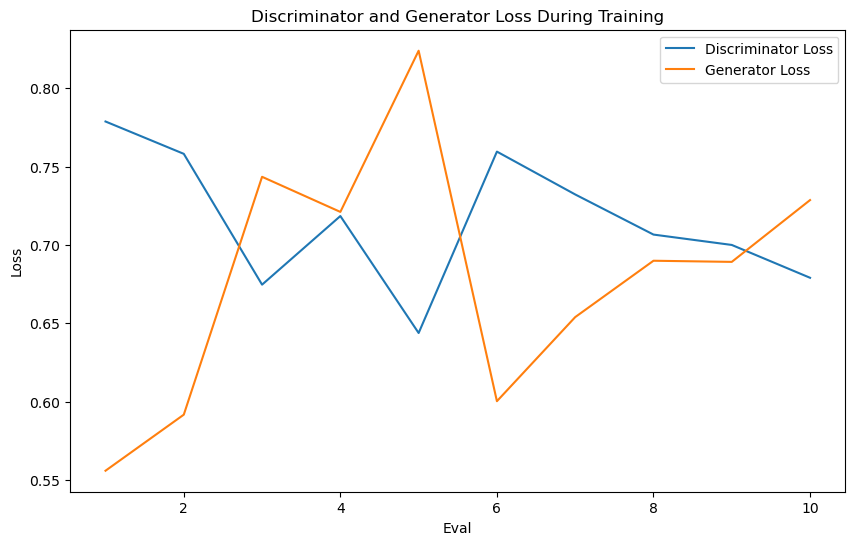

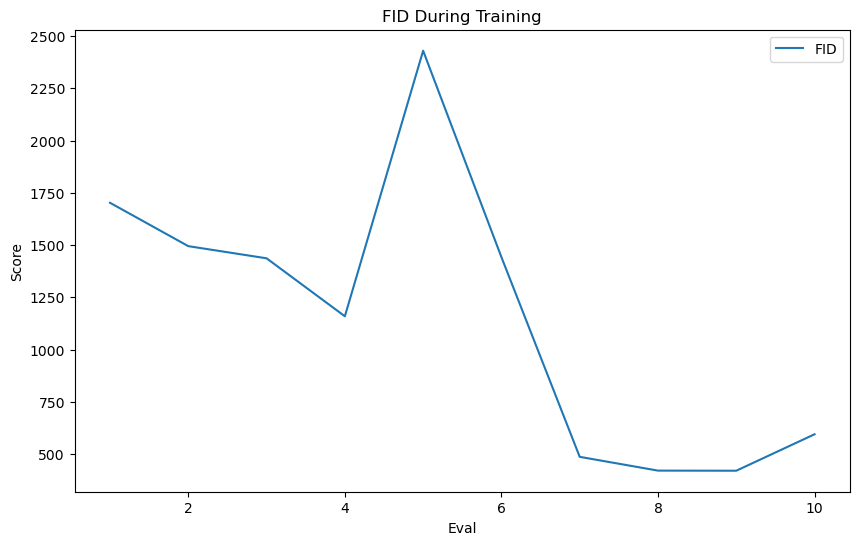

In [6]:
# size of the latent space
latent_dim = 128
# create the discriminator
d_model = define_discriminator()
d_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00002, beta_1=0.5), metrics=['accuracy'])

# create the generator
g_model = define_generator(latent_dim)
g_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00002, beta_1=0.5))

# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00002, beta_1=0.5))

# load image data
dataset = load_real_samples()
# train model
metrics = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128)

epochs = range(1, len(metrics['d_loss']) + 1)
plot_metrics(metrics, epochs)

In [7]:
metrics['fid']

[1702.3695246568573,
 1494.8340999801887,
 1436.68390066332,
 1159.2916274053537,
 2429.977301712425,
 1442.2542734690464,
 486.675207329753,
 420.73867961757,
 420.22991857557287,
 594.6534936194249]

1/1 [==============================] - 1s 568ms/step


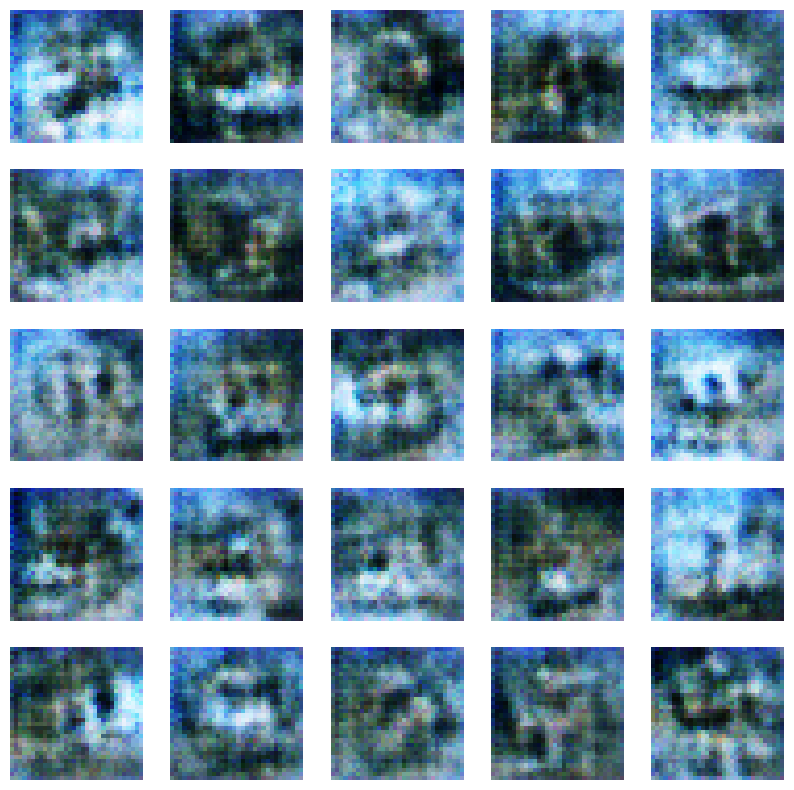

In [8]:
def generate_images(generator_model, latent_dim, n_samples):
    # Generate points in latent space
    latent_points = generate_latent_points(latent_dim, n_samples)
    # Update latent points with provided labels
    # Generate images
    images = generator_model.predict(latent_points)
    # Scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    # Plot images
    plt.figure(figsize=(10, 10))
    for i in range(n_samples):
        plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

# Example usage
generate_images(g_model, latent_dim, n_samples=25)